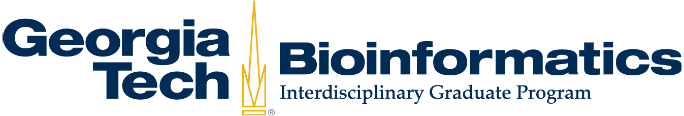

<div class="alert alert-block alert-info">
    <h1>BIOS 4150/BIOL 6150</h1>
    <h3>Instructor: Dr. King Jordan</h3>
    <p>Shivam Sharma (shivamsharma13@gatech.edu), Nilavrah Sensarma (nsensarma3@gatech.edu), Bengy Gyimah-Asamoah, (bgyimaha3@gatech.edu)

</p>
</div>

<div class="alert alert-block alert-warning">
    <h2>Project 8 (Pharmacogenomics) starter notebook</h2>
    <h3>Deadline: 11:59PM, November 18th, 2024</h3>
</div>

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>Do not delete any comments or information boxes the starter notebook comes with</p>
</div>

---

# **1. Knowing your data**
### *Total Questions: 3*
### *Total Points: 5+5+20 = 30*


---

<div class="alert alert-block alert-warning">
    <h3>1.1 Download the information file</h3>
    <p>For this project, you will need to access PharmGKB annotated variants. PharmGKB has multiple resources, but we will focus on the clinical variant data file. This file should have variant-drug pairs and level of evidence for all clinical annotations.</p>
    <p>Download the file and show top 5 lines of the file</p>
</div>

In [39]:
import pandas as pd
import os 
import requests
!pip install tqdm
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re
import subprocess
import matplotlib.pyplot as plt
igsr_df = pd.read_csv('~/project8_sandbox/igsr_samples.tsv', sep = '\t')


Defaulting to user installation because normal site-packages is not writeable


In [3]:
#Show the file here.
!head -5 clinicalVariants.tsv

variant	gene	type	level of evidence	chemicals	phenotypes
CYP2C9*1, CYP2C9*2, CYP2C9*3, CYP2C9*13	CYP2C9	Metabolism/PK	1A	meloxicam	
CYP2C9*1, CYP2C9*3, CYP2C9*13	CYP2C9	Metabolism/PK	1A	lornoxicam	
CYP2C9*1, CYP2C9*2, CYP2C9*3	CYP2C9	Metabolism/PK	1A	siponimod	
rs17376848	DPYD	Toxicity	1A	capecitabine	Neoplasms


<div class="alert alert-block alert-warning">
    <h3>1.2 Filter the file</h3>
    <p>Although star alleles can be processed, we will only focus on dbSNP annotated variants (those that have rs ids)</p>
    <p>Filter the file for dbSNP annotated variants and count them</p>
    
</div>

In [4]:
# wc -l after filtering 
clnvar = pd.read_csv('clinicalVariants.tsv', sep = '\t')
clnvar = clnvar[clnvar['variant'].str[:2] == 'rs']
clnvar.to_csv('clinicalVariants_filtered.tsv', index = False, sep = '\t')
print(len(clnvar))
!wc -l clinicalVariants_filtered.tsv


4575
4576 clinicalVariants_filtered.tsv


<div class="alert alert-block alert-warning">
    <h3>1.3 Think ahead!</h3>
    <p><b>Eventual Goal:</b> Quantify the presence of the variants obtained in Question 1.2. We will extract these variants from the 1000 genomes VCF file.</p>
    <p>Use whatever resource you want to. The end goal is to have appropriate information about these variants obtained in 1.2.</p>
    <p>If you have to subset a VCF file (extract variants of interest), you will need information such as CHR, POS, etc. Although you can simply use the ID column to extract variants, that might not work everywhere.</p>
    <p>If you want to use R, please feel free to do so. Add screenshots from PACE-ICE RStudio here. Your R workflow would essentially output a nice tsv file which you use later to extract variants</p>
    
</div>

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>We do not want you to use dbSNP IDs (rs ids) to extract variants from the 1000 genomes data. The 1000 genomes file we provided you has dbSNP IDs and a simple bcftools command will do the job. But most VCF files you will come across in your work will not have dbSNP IDs. Therefore, we expect you to find relevant information about the variants obtained in Question 1.2 before moving to section 2.</p>
</div>

In [5]:
clnvar.iloc[:5, :]

,variant,gene,type,level of evidence,chemicals,phenotypes
3,rs17376848,DPYD,Toxicity,1A,capecitabine,Neoplasms
4,rs2297595,DPYD,Toxicity,1A,capecitabine,Neoplasms
5,rs1801265,DPYD,Toxicity,1A,capecitabine,Neoplasms
8,rs1801160,DPYD,Toxicity,1A,capecitabine,Neoplasms
9,rs1801159,DPYD,Toxicity,1A,capecitabine,Neoplasms


In [6]:
#query ENSMBLE REST Api to get chrm and pos
def query_ensembl(rsid):
    url = f"https://rest.ensembl.org/variation/human/{rsid}"
    headers = {"Content-Type": "application/json"}
    response = requests.get(url, headers = headers)
    if response.status_code == 200:
        data = response.json()
        mappings = data.get("mappings", [])
        if mappings:
            chromosomes = []
            positions = []
            for mapping in mappings:
                chromosomes.append(mapping['seq_region_name'])
                positions.append(mapping['start'])
            if len(chromosomes) > 1:
                #print(f"multi-position variant, returning {rsid} for requery if desired") 
                return [rsid, chromosomes, positions]
            else:
                return [rsid, chromosomes[0], positions[0]]
                
        else:
            print(f"No position data for {rsid}")
    else:
        print(f"FAILURE Status Code: {response.status_code}")

#since query on its own takes ~4hrs... multiprocess it!     
#"chunk" (set of IDs) mapping func
def process_chunk(rsid_list):
    results = []
    for rsid in rsid_list:
        results.append(query_ensembl(rsid))
    return results

#actual parallel func
def parallel_query(clnvar, num_cores=None):
    if num_cores is None: #set all available cores to work less 2 for I/O management
        num_cores = max(1, cpu_count() - 2)
        if num_cores > 12:
            num_cores = 12 #will hit request max otherwise :(
    rsids = clnvar['variant'].tolist()
    #split IDs into chunks
    chunk_size = len(rsids) // num_cores
    chunks = [rsids[i:i + chunk_size] for i in range(0, len(rsids), chunk_size)]
    if len(rsids) % num_cores != 0:
        chunks[-1].extend(rsids[len(chunks) * chunk_size:])
    #run!
    with Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(process_chunk, chunks), total=len(chunks))) #tqdm doesn't work well here :(
    final_results = [item for sublist in results for item in sublist]
    return final_results

In [ ]:
if __name__ == "__main__":
    position_map = parallel_query(clnvar) 



In [158]:
# **2. Extract data**
### *Total Questions: 2*
### *Total Points: 5+15=20*


In [159]:
#results = pd.DataFrame(results)
#filter out errors from API
position_map = [x for x in position_map if x is not None]

#clean up positions that had multiple mappings (all 1sts ended up being the ones we want)
cleaned_multipos = [list([x[0], x[1][0], x[2][0]]) for x in position_map if len(x[1]) > 2 and type(x[2]) == type([]) ]
position_map = [x for x in position_map if len(x[1]) < 2 and type(x[2]) != type([])]
position_map = cleaned_multipos + position_map#filter out non-numerical chroms that we don't want

#create a dataframe
positions_df = pd.DataFrame(position_map, columns = ['rsid', 'chr', 'pos'])
positions_df = positions_df[positions_df["chr"].str.isdigit().fillna(False)]

#create bedfile with results
positions_df["start"] = positions_df["pos"] - 1  #reduce index for bed file start
positions_df["end"] = positions_df["pos"]   
positions_df["chr"] = "chr" + positions_df["chr"].astype(str)
positions_df[["chr", "start", "end"]].to_csv("positions.bed", sep="\t", header=False, index=False)


<div class="alert alert-block alert-warning">
    <h3>2.1 Subset the VCF files</h3>
    <p>2.1.1 How many variants obtained in 1.2 were found in the 1000 genomes data?</p>
    <p>2.1.2 Subset the VCF files (all chromosomes) and write the number of Pharmacogenomic variants found in chromosome 2.</p>
</div>

In [163]:
#create file names for source and subset vcfs
filenames = []
source_names = []
for file in os.listdir('/storage/ice-shared/biol6150/Data/1000Genomes'):
    filename = os.fsdecode(file)
    if filename.endswith(".vcf.gz"):
        #get chrome number for the new filename 
        match = re.search(r'\.chr(\d+)\.', filename)
        chr_num = match.group(1)

        filenames.append(f'./pharmcom{chr_num}.vcf.gz')
        source_names.append(f'/storage/ice-shared/biol6150/Data/1000Genomes/{filename}')

#loop over all 1000 genomes files and save subset ones that intersect with our pharmcom variants
for i in range(len(source_names)): 
    subprocess.run(["bcftools", "view", "-R", "positions.bed", "-Ov", "-o", filenames[i], source_names[i]])
    


# **3. Pharmacogenomic variant distribution in 1000 genomes populations**
### *Total Steps: 3*
### *Total Points:  25+5+20=50*


---

<div class="alert alert-block alert-warning">
    <h3>3.1 Distribution by populations</h3>
        <p>For the 26 populations present in the 1000 genomes data, show the distribution of pharmaocgenomic variant frequencies stratified by "level of evidence"</p><hr>
    <h4>Step 1 - Find variant frequencies for all pharmacogenomic variants within each population.</h4>
    <p>The end result of this step should be a TSV file which has <i>x rows and 26 + w columns</i>. x = number of pharmacogenomic variants found in 1000 genome VCF files. 26 columns represent each 1000 genome population. w will be additonal metadata about the pharmacogenomic variant such as CHR POS ID etc</p>
    <p>This is a good exercise to implement a nice bash or python based solution where you can streamline a lot of things.</p>
    <h4>Step 2 - Annotate variants by level of evidence</h4>
    <p>This should be easy, just annotate them in your code or create separate files.</p>
    <h4>Step 3 - Visualize using boxplots</h4>
    <p>Every level of evidence will have it's set of 26 box plots showing frequency distribution of all variants </p>
    <p>In the end you will have multiple box plot graphs like the one shown below. Each graph will correspond to a specific level of evidence as determined by PharmaGKB (1A, 1B, 2A, 2B, ... , etc)</p>
</div>

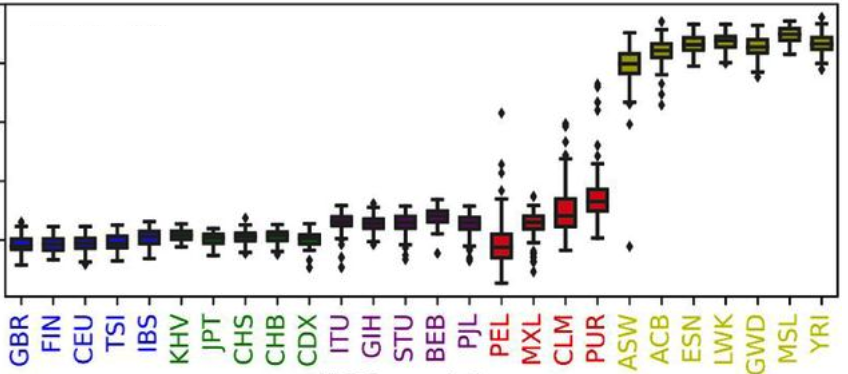

In [8]:
#popuation df 
igsr_df = pd.read_csv('~/project8_sandbox/igsr_samples.tsv', sep = '\t')

#combine into 1 big vcf for whole genome
!bcftools concat pharmcom1.vcf.gz pharmcom2.vcf.gz pharmcom3.vcf.gz pharmcom4.vcf.gz pharmcom5.vcf.gz pharmcom6.vcf.gz pharmcom7.vcf.gz pharmcom8.vcf.gz pharmcom9.vcf.gz pharmcom10.vcf.gz pharmcom11.vcf.gz pharmcom12.vcf.gz pharmcom13.vcf.gz pharmcom14.vcf.gz pharmcom15.vcf.gz pharmcom16.vcf.gz pharmcom17.vcf.gz pharmcom18.vcf.gz pharmcom19.vcf.gz pharmcom20.vcf.gz pharmcom21.vcf.gz pharmcom22.vcf.gz -Oz -o full_genome.vcf.gz



Checking the headers and starting positions of 22 files
Concatenating pharmcom1.vcf.gz	0.115400 seconds
Concatenating pharmcom2.vcf.gz	0.089925 seconds
Concatenating pharmcom3.vcf.gz	0.069993 seconds
Concatenating pharmcom4.vcf.gz	0.071758 seconds
Concatenating pharmcom5.vcf.gz	0.059911 seconds
Concatenating pharmcom6.vcf.gz	0.092606 seconds
Concatenating pharmcom7.vcf.gz	0.069383 seconds
Concatenating pharmcom8.vcf.gz	0.041824 seconds
Concatenating pharmcom9.vcf.gz	0.055590 seconds
Concatenating pharmcom10.vcf.gz	0.008374 seconds
Concatenating pharmcom11.vcf.gz	0.008138 seconds
Concatenating pharmcom12.vcf.gz	0.007985 seconds
Concatenating pharmcom13.vcf.gz	0.008038 seconds
Concatenating pharmcom14.vcf.gz	0.007967 seconds
Concatenating pharmcom15.vcf.gz	0.007968 seconds
Concatenating pharmcom16.vcf.gz	0.007950 seconds
Concatenating pharmcom17.vcf.gz	0.008015 seconds
Concatenating pharmcom18.vcf.gz	0.008112 seconds
Concatenating pharmcom19.vcf.gz	0.007997 seconds
Concatenating pharmcom

<div class="alert alert-block alert-danger">
    <h2>Alert!</h2>
    <p>If you use R, please provide ample evidence of work.</p>
    <p>For R use, you should add appropriate screenshots and the R code here in this notebook as well. R code might not run for you on PACE-ICE Jupyter engine right now, but it will work for anyone replicating this work somehwere else (that anyone could be the "future you")</p>
</div>

In [9]:
!bcftools query -l ~/biol6150/Data/1000Genomes/phase3.chr15.GRCh38.GT.crossmap.vcf.gz > ids.txt
ids_in_sample = []
with open("ids.txt", "r") as f:
    for line in f:
        ids_in_sample.append(line[:-1])
#subset to just those in population
ids_in_pop = list(igsr_df['Sample name'])
ids_in_pop = list(set(ids_in_pop) & set(ids_in_sample))


In [11]:
genomes1000_igsr_subset_df = igsr_df[igsr_df['Sample name'].isin(ids_in_pop)]
population_code_list = list(set(genomes1000_igsr_subset_df['Population code']))

#loop over each population, subsetting the vcfs to each population
for i in range(len(population_code_list)):
    subpop = population_code_list[i]
    pop_df = genomes1000_igsr_subset_df[genomes1000_igsr_subset_df['Population code'] == subpop]
    pop_df['Sample name'].to_csv('sub_population.txt', index=False, header=False, sep = '\t')
    subprocess.run(["bcftools", "view", "-S", "sub_population.txt", "-Ov", "-o", f"./population_vcfs/{subpop}.vcf.gz", "full_genome.vcf.gz"])
    


In [10]:
#loop over each population, filling in allele freqs for each rsid and extracting
dfs = []
for i in range(len(population_code_list)):
    subpop = population_code_list[i]
    #recalc allele freqs
    subprocess.run(["bcftools", "+fill-tags", f"population_vcfs/{subpop}.vcf.gz", '-Oz', '-o', f"population_vcfs/{subpop}_recal.vcf.gz"])    #recalculate the allele freq headers that are stuck with the full pop
    #extract
    subprocess.run(["bcftools", "query", "-f", "%ID\t%CHROM\t%POS\t%REF\t%ALT\t%AF\n", f"population_vcfs/{subpop}_recal.vcf.gz", '-o', 'subpop_freq.txt'])
    _df = pd.read_csv('subpop_freq.txt', sep = '\t', header = None)
    _df.columns = ['rsid', 'chrm', 'pos', 'ref', 'alt', 'freq']
    _df = _df[['rsid', 'freq']]
    dfs.append(_df)


In [69]:
#loop over each df (one for each population) and join by "rsid" (index)
df_final = pd.merge(dfs[0], dfs[1], left_index = True, right_index = True)
df_final.drop(['rsid_x', 'rsid_y'], axis = 1, inplace = True)
df_final.columns = population_code_list[:1 + 1]
for i in tqdm(range(2, len(population_code_list))):
    df_final = pd.merge(df_final, dfs[i], left_index = True, right_index = True)
    df_final.drop(['rsid'], axis = 1, inplace = True)
    df_final.columns = population_code_list[:i + 1]
df_final['rsid'] = dfs[0]['rsid'] #return actual rsid names to dataframe (some are multiallelic so joining on them directly caused alternating dupes)
df_final.drop_duplicates(inplace = True)
                        

100%|██████████| 25/25 [00:00<00:00, 989.90it/s]


In [ ]:
#Sort columns roughly from highest to lowest medians
sorted_columns = df_final.iloc[:, :-1].median().sort_values().index
df_final = df_final[sorted_columns]

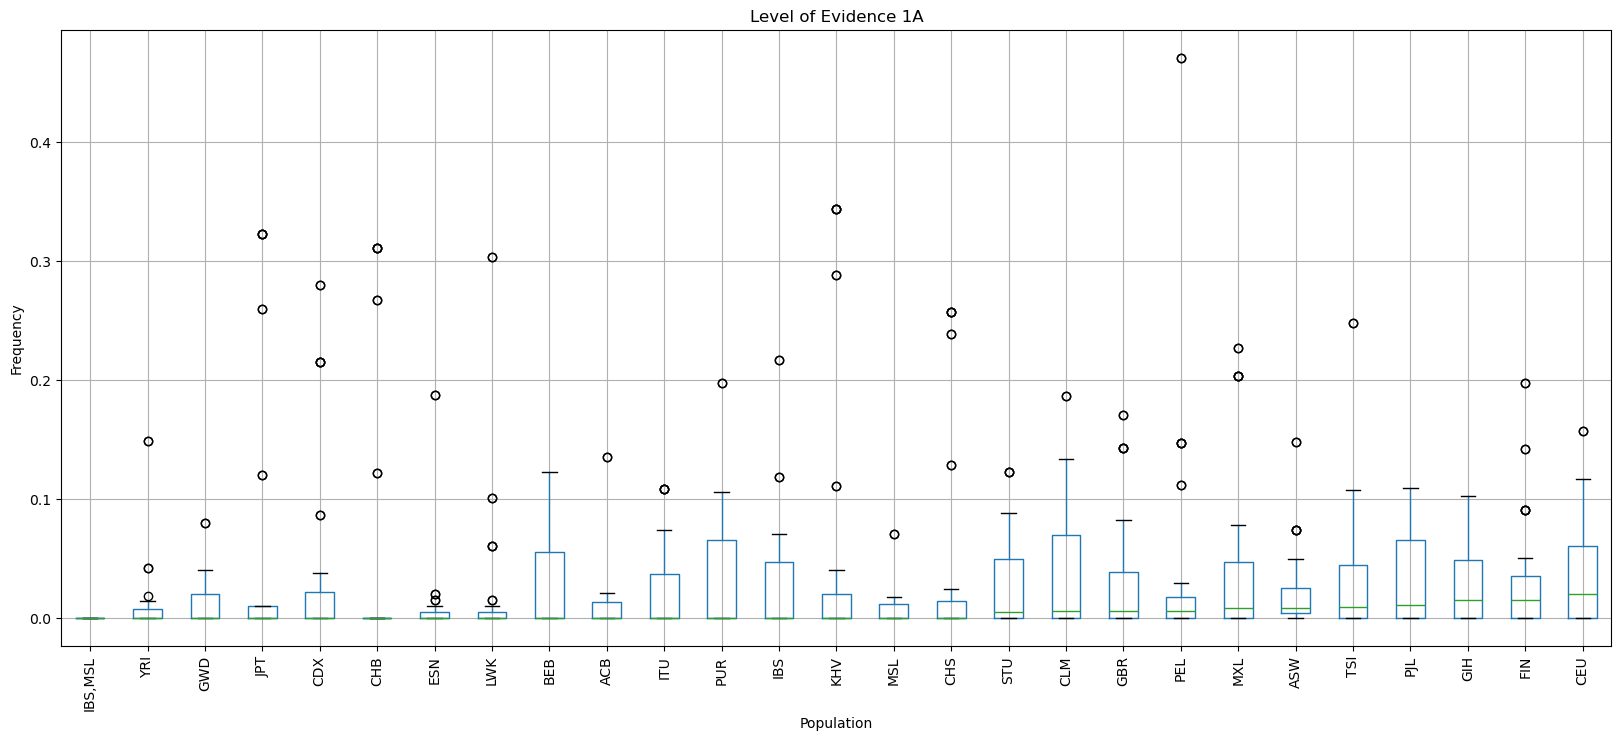

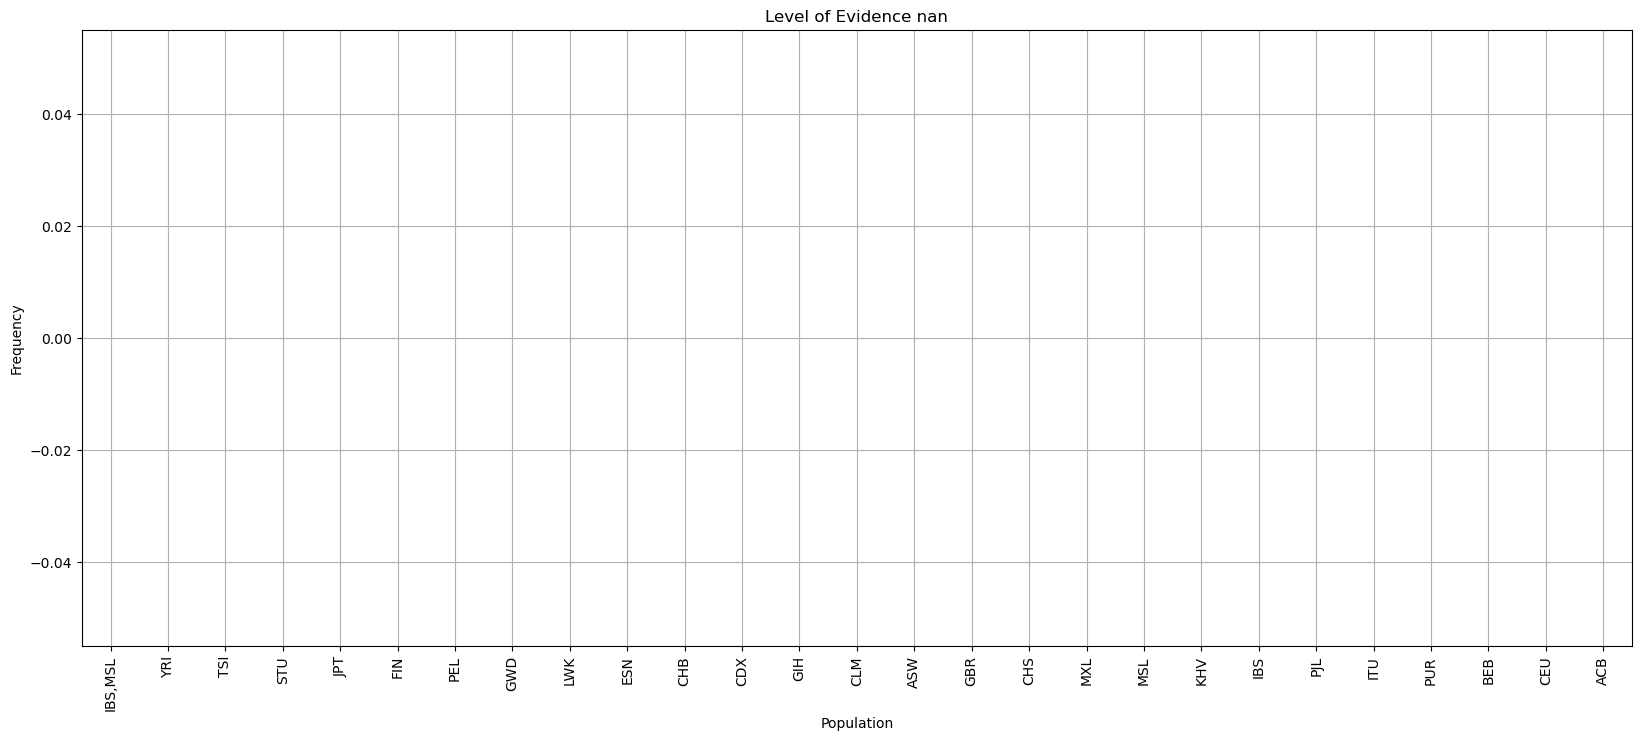

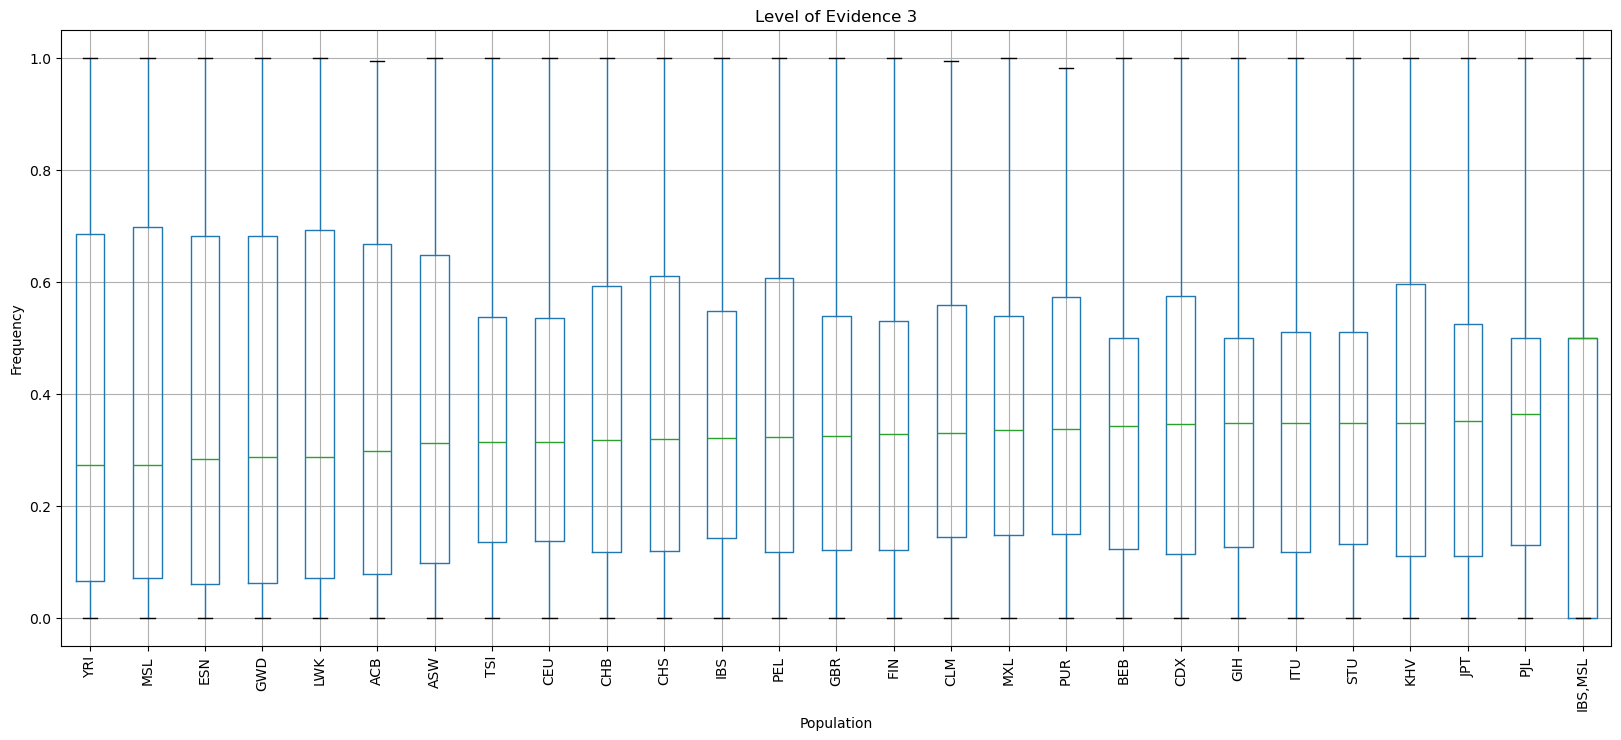

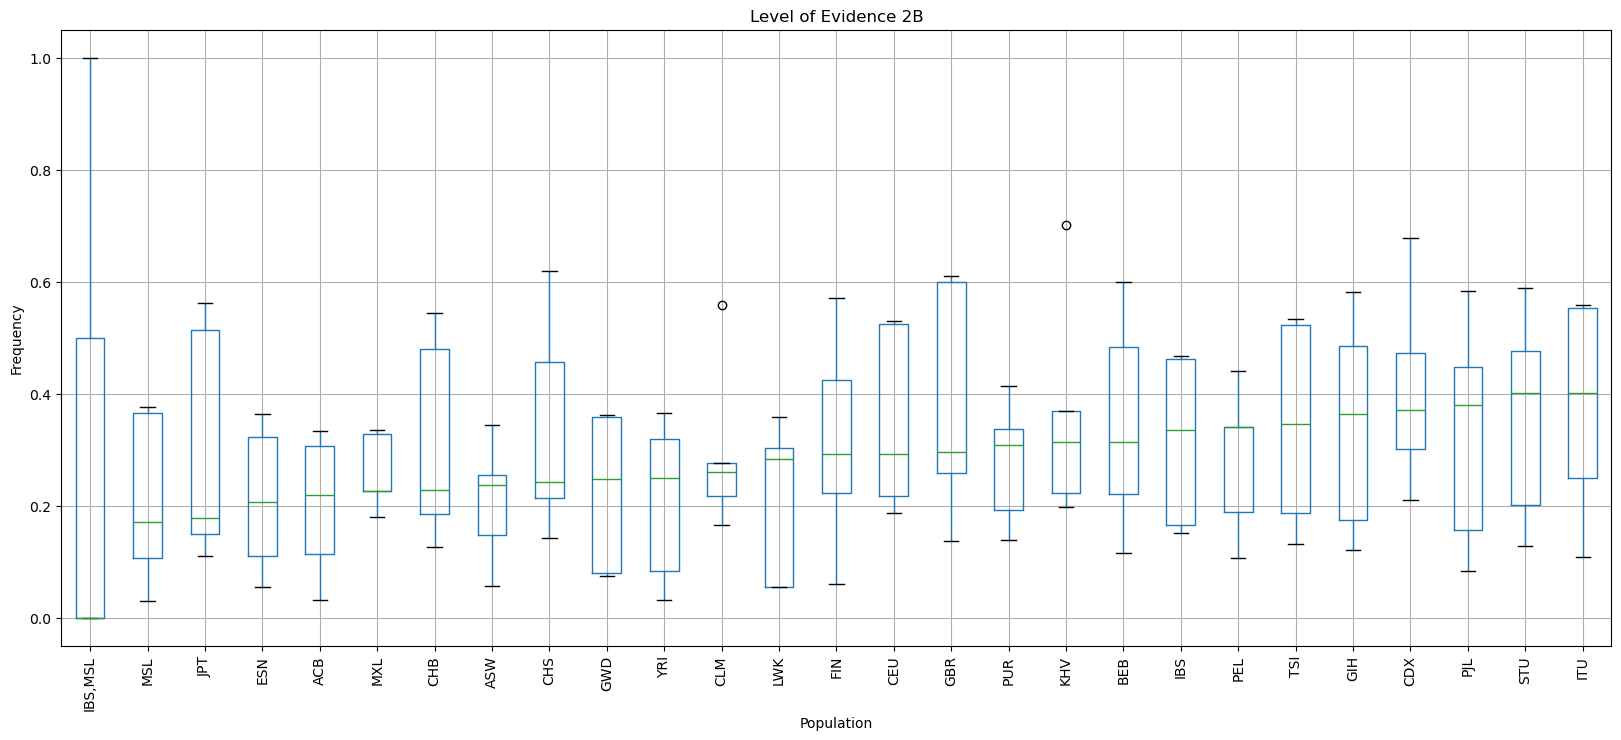

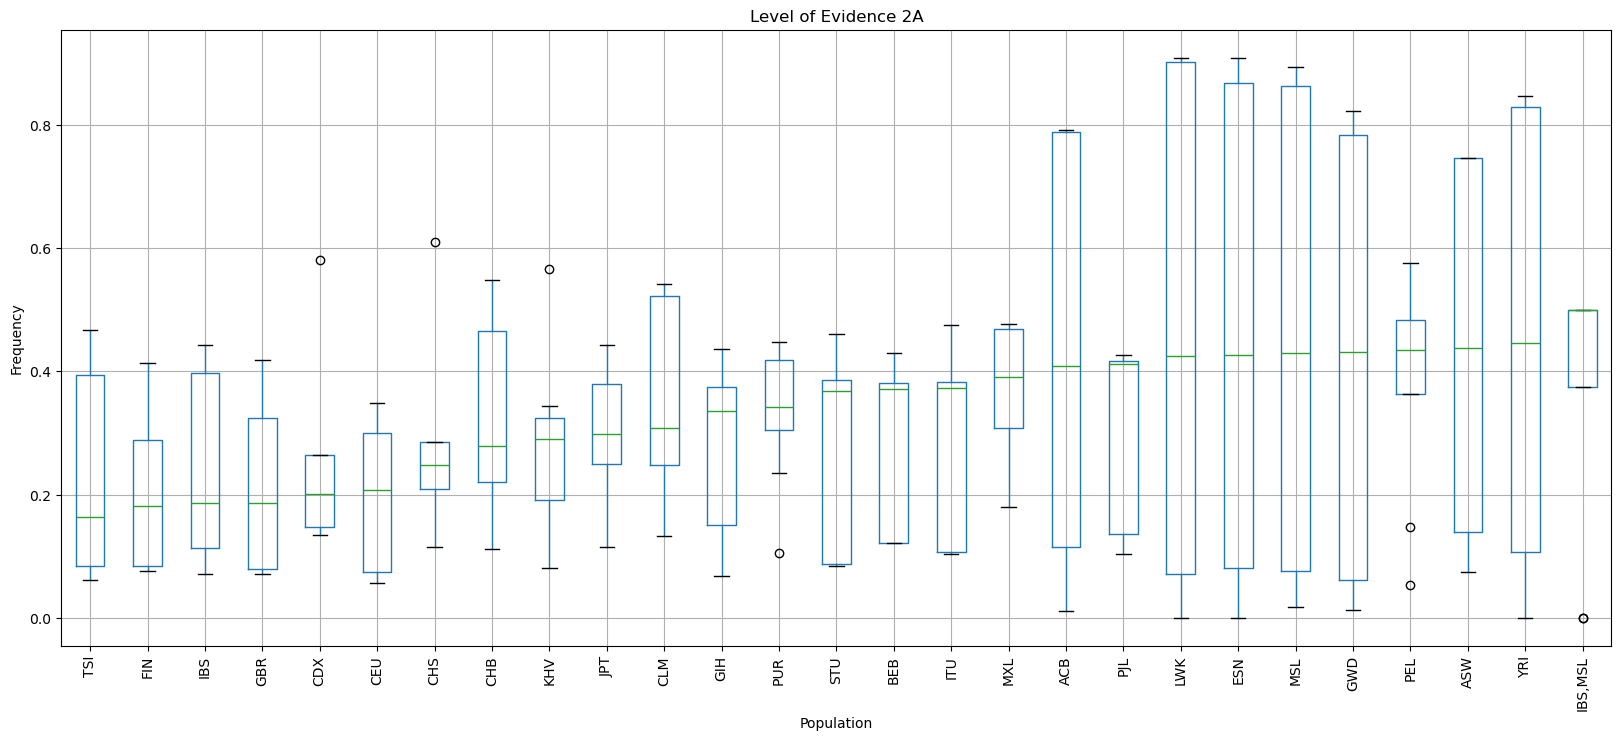

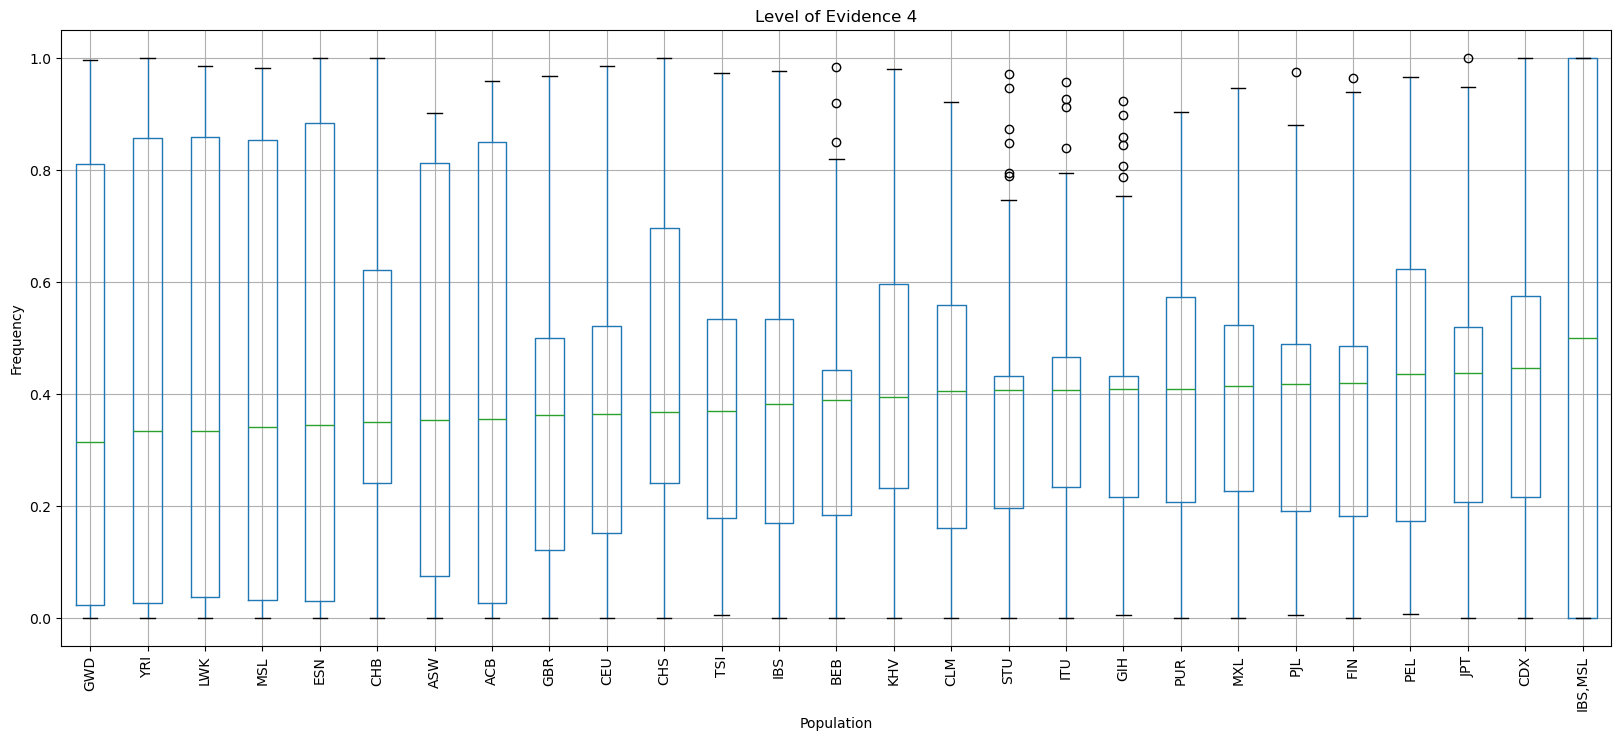

In [70]:
#boxplots
def boxplot(df, level_group):
    sorted_columns = df.median().sort_values().index
    df = df[sorted_columns]
    plt.figure(figsize=(20, 8))  # Adjust figure size for better visibility
    df.boxplot()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.title(f'Level of Evidence {level_group}')
    plt.xlabel('Population')
    plt.ylabel('Frequency')
    plt.show()
set(df_final2['level of evidence'])

df_final = pd.merge(df_final, clnvar, how = 'left', left_on = 'rsid', right_on = 'variant')
evidences = list(set(df_final['level of evidence']))
for evidence in evidences:
    df = df_final[df_final['level of evidence'] == evidence]
    df = df.iloc[:, :27]
    boxplot(df, evidence)
    
